## Initialize Dependencies

In [50]:
import os
from utilities import init_db_handle
from couchbase.n1ql import N1QLQuery
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Initialize Database Handle

In [5]:
data_folder = './Data'
cb = init_db_handle(data_folder)

-[Return list of document identifier](https://forums.couchbase.com/t/how-n1ql-get-doc-id/4161/2)  
-[Import N1QL query speed](https://dzone.com/articles/count-amp-group-faster-using-n1ql)  
-[Fill a list from a generator](https://stackoverflow.com/questions/9811222/fill-a-list-from-a-generator)

## Query a database record

In [6]:
row_iter = cb.n1ql_query(N1QLQuery('SELECT meta(AustinTx311Data).id FROM AustinTx311Data LIMIT 1'))
recordid = [elem['id'] for elem in itertools.islice(row_iter,None)]
rec = cb.get(recordid[0])
rec.value

{'city': 'AUSTIN',
 'closeday': 4,
 'closehour': 12,
 'closemonth': 1,
 'closeyear': 2014,
 'councildistrict': 10,
 'county': 'TRAVIS',
 'createdday': 1,
 'createdhour': 1,
 'createdmonth': 1,
 'createdyear': 2014,
 'lastupdateday': 4,
 'lastupdatehour': 11,
 'lastupdatemonth': 1,
 'lastupdateyear': 2014,
 'latitudecoordinate': 30.3484472,
 'latitudelongitude': {'loc': [30.3484472, -97.77776831],
  'title': '14-00000197'},
 'longitudecoordinate': -97.77776831,
 'mappage': '524P',
 'maptile': 'MG29',
 'methodreceived': 'Phone',
 'owningdepartment': 'Animal Services Office',
 'srdescription': 'Dangerous/Vicious Dog Investigation',
 'srlocation': '4507 KNAP HOLW, AUSTIN, TX',
 'srstatus': 'Closed',
 'srtypecode': 'COAACDD',
 'stateplanexcoordinate': 3102607.36012251,
 'stateplaneycoordinate': 10099724.3223682,
 'statuschangeday': 4,
 'statuschangehour': 12,
 'statuschangemonth': 1,
 'statuschangeyear': 2014,
 'streetname': 'KNAP',
 'streetnumber': 4507,
 'zipcode': 78731}

## Initialize a Secondary Index

In [27]:
cb.n1ql_query(N1QLQuery('CREATE INDEX idxsrtypecode ON `AustinTx311Data` (srtypecode)'))
cb.n1ql_query(N1QLQuery('CREATE INDEX idxcreatedyear ON `AustinTx311Data` (createdyear)'))
cb.n1ql_query(N1QLQuery('CREATE INDEX idxcreatedmonth ON `AustinTx311Data` (createdmonth)'))

## Compute a histogram of 311 calls for 2014
-[Sort DataFrame month colunn](https://stackoverflow.com/questions/46755841/pandas-dataframe-month-int-to-month-name-in-order)  

In [48]:
year = 2014

request = cb.n1ql_query(N1QLQuery('SELECT createdmonth, count(*) from `AustinTx311Data`' +\
                                  'WHERE createdyear=' + str(year) + ' GROUP BY createdmonth'));

histogram = [{'createdmonth': elem['createdmonth'], 'count': elem['$1']}
             for elem in itertools.islice(request, None)]

createdmonth = [elem['createdmonth'] for elem in histogram]

histogram = np.array(histogram)
histogram = histogram[np.argsort(createdmonth)]

for idx in range(0, len(histogram)):
    datetimeobj = datetime(year, histogram[idx]['createdmonth'], 1)
    histogram[idx]['createdmonth'] = datetimeobj.strftime('%b')

df = pd.DataFrame.from_dict(list(histogram))

### Plot 2014 311 calls / month histogram
-[Pandas Dataframe barplot](https://stackoverflow.com/questions/35168016/unable-to-plot-dataframe-using-seaborn-barplot)  
-[Style Seaborn plot](https://seaborn.pydata.org/tutorial/aesthetics.html)  
-[Set Seaborn font size](https://stackoverflow.com/questions/25328003/how-can-i-change-the-font-size-using-seaborn-facetgrid)

Text(0.5,1,'2014 Austin Tx 311 Calls / Month')

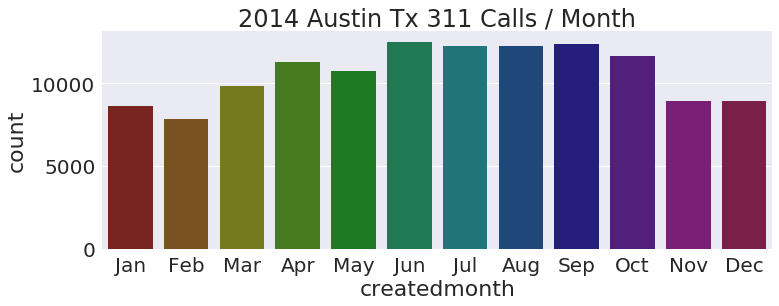

In [78]:
plt.figure(figsize=(12,4))
sns.set(font_scale=2)
sns.set_palette(sns.hls_palette(12, l=.3, s=.8))
sns.barplot(x='createdmonth', y='count', data=df)
plt.title('2014 Austin Tx 311 Calls / Month')

In [12]:
request = cb.n1ql_query(N1QLQuery('SELECT srtypecode, count(*) FROM `AustinTx311Data` ' +\
                                  'WHERE createdyear=2014 GROUP BY srtypecode;'))

srtypecode_histogram = [{'srtypecode': elem['srtypecode'], 'count': elem['$1'], 'srdescription':None}
                        for elem in itertools.islice(request, None)]

In [9]:
df = pd.DataFrame.from_dict(srtypecode_histogram)
df = df.sort_values(by=['count'], ascending=False)
df = df.reset_index(drop=True)
df.head(5)

,count,srtypecode
0,19646,CODECOMP
1,9740,ACLONAG
2,8996,TRASIGMA
3,6677,LOUDMUS1
4,6308,ACINFORM


In [11]:
q = N1QLQuery("SELECT srdescription from `AustinTx311Data` WHERE srtypecode='ACLONAG' LIMIT 1",0)
for row in cb.n1ql_query(q):
    print(row)

{'srdescription': 'Loose Dog'}
